## **DEMO:  OmdenaSaudi liverHCC with Deep Learning and XAI**
   
### **PreReqs**
- google Colab
- image data;  in gcp_bucket/Dataset_PAIP2019_Omdena
- binary model;  upload to google colab;  Model/;  see BEST_MODEL_PATH config
   
### **Other Notes**
- this notebook requires ~15GB of RAM when using gpu (cuda);  it may crash if using Colab Free subscription
- workaround:  change the default device type config to 'cpu'

### **Attempt:  run Google Colab Free (cpu)**
- Success:  this notebook can be run under Google Colab Free


### **Install libs**

In [1]:
!pip install -qU livelossplot
!pip install -qU torchmetrics
!pip install grad-cam==1.4.6      #--- grad-cam v1.4.7 is giving install errors for some reason

!pip install imagecodecs
!pip install tifffile
!apt update && apt install -y openslide-tools
!pip install openslide-python
!pip install pynvml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38241 sha256=a49dbc4af2ed179b1bf2d8773472d71986f10cd2c545122f72eb58caa295f357
  Stored in directory: /root/.cache/pip/wheels/3c/6c/04/9a543775e9f25f6c441180a552456f1696167439459730ff87
Successfully built grad-cam
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 41.9 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ Packages [80.0 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease

### Install GCSFuse to locally mount buckets

In [2]:
%%bash

export GCSFUSE_REPO=gcsfuse-`lsb_release -c -s`
echo "deb http://packages.cloud.google.com/apt $GCSFUSE_REPO main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

deb http://packages.cloud.google.com/apt gcsfuse-focal main
OK


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  98481      0 --:--:-- --:--:-- --:--:-- 98481


In [3]:
%%bash

sudo apt-get update
sudo apt-get install gcsfuse=0.42.5

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [5,002 B]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:8 http://security.ubuntu.com/ubuntu focal-security InRelease
Get:9 http://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [2,356 B]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Fetched 7,358 B in 2s (4,623 B/s)
Reading package lists...
Read

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [4]:
#--- Only if using google's hosted runtime, including Colab:
from google.colab import auth
auth.authenticate_user()

In [5]:
!mkdir gcp_bucket


In [6]:
!gcsfuse --implicit-dirs full-datasets-omdena-lihc-2 gcp_bucket

I0629 16:00:37.937410 2023/06/29 16:00:37.937361 Start gcsfuse/0.42.5 (Go version go1.20.3) for app "" using mount point: /content/gcp_bucket


### **Load libs**

In [7]:
import os
import shutil
import tifffile as tiff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
import openslide
from tqdm import tqdm
import re
import random

import torch
import torch.nn as nn

from torchvision.datasets.vision import VisionDataset
from torchvision import transforms
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_tensor
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import deeplabv3_resnet101

from torchmetrics import MeanMetric
from livelossplot import PlotLosses
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import requests
import torchvision

from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
from pytorch_grad_cam import GradCAM

##**Load Data**

### **configuration**

In [8]:
pth_data_dir = 'gcp_bucket/Dataset_PAIP2019_Omdena/'
pth_dataset_valid = 'gcp_bucket/All_chunks_Validation_df.csv'
pth_dataset_train = 'gcp_bucket/All_chunks_Training_df.csv'
#'/content/gcp_bucket/Dataset_PAIP2019_Omdena/Validation/'

data_dir = pth_data_dir
dataset_test = pth_dataset_valid
dataset_train = pth_dataset_train

data_batch_size = 3         #--- decrease the number of images loaded, processed if the notebook crashes due to limited RAM

NUM_EPOCHS = 10 # 50
BATCH_SIZE = data_batch_size
NUM_CLASSES = 3

# path to save model weights
BESTMODEL_PATH = r"model_deeplabv3_r50_full_training_dataset_80-20_split_10epochs_no-norm_vhflip30.pth"  #--- path to save model weights
#BESTMODEL_PATH = r"model_deeplabv3_r50_full_training_dataset_80-20_split_10epochs_no-norm_vhflip30_062223.pth"  #--- path to save model weights
#MODEL_FULLPATH = 'Model/' + BESTMODEL_PATH
MODEL_FULLPATH = 'gcp_bucket/Model_weights/' + BESTMODEL_PATH
model_path = MODEL_FULLPATH

DEFAULT_DEVICE_TYPE = ('cuda' if torch.cuda.is_available() else 'cpu')       #--- cuda if gpu; cpu if on Colab Free
DEFAULT_BACKBONE_MODEL = 'r50'
backbone_model_name = DEFAULT_BACKBONE_MODEL



### **random dataset loader**

In [9]:
# function to select min(bg, vt, wt) amount of chunks for each class randomly from the whole list.

def random_dataset2(dataset_path, fraction = 0.2, seed = 1, test = False, limit_unique = None):

    # prepare file_list, lambda for filtering and dict of class types in chunks
    fle_list = []

    types = ['background', 'viable', 'whole']

    # load the df with the files path and other info
    # extract unique ID of slides
    # extract unique class present in each slide ID
    tmpdf = pd.read_csv(dataset_path)
    fle_names = np.unique(tmpdf['file_name'])

    #--- determine unique classes
    clss = np.unique(tmpdf['class'])

    #--- restrict the number of unique file names
    if (limit_unique != None):
      print("[TRACE random_dataset2]  num fle_names pre-restrict\t", len(fle_names))
      fle_names = np.random.choice(fle_names, size=limit_unique, replace=False)
      fle_names.sort()
      print("[TRACE random_dataset2]  num fle_names post-restrict\t", len(fle_names))

    # set the seed
    # group by slide ID and class per slide and count them
    random.seed(seed)
    tmpdf_grp = tmpdf.groupby(['file_name', 'class']).size().unstack()

    # loop per each slide ID and extract a random sample per class of each slide ID of size 'files'
    # argument or all of them if < files
    for fle in fle_names:
        bg, vt, wt = tmpdf_grp.loc[fle]
        num_fls = min(bg, vt, wt) if not test else int(np.ceil((min(bg, vt, wt)*fraction)))

        for cls in types:
            tmp_list = tmpdf[(tmpdf.file_name == fle) & (tmpdf['class'] == cls)].file.tolist()
            fle_list = fle_list + random.sample(tmp_list, num_fls)

    # return the fle_list of training/val
    print("[TRACE random_dataset2]  fle_list \t", fle_list)
    return fle_list

### **segmentation dataset class**

In [10]:
class SegmentationDataset2(VisionDataset):
    def __init__(self, root_dir, dataset_train, seed, fraction, subset,
                image_size = (512, 512), transforms=None):#,files = 500):

        super().__init__(root_dir, transforms)

        self.root_dir = root_dir
        # self.file_list = file_list
        # self.test_files = int(np.around((files * fraction)))
        self.transforms = transforms

        if seed:
          np.random.seed(seed)
          #indices = np.arange(len(self.file_list))
          #np.random.shuffle(indices)
          #self.file_list = self.file_list[indices]

        self.file_names = random_dataset2(dataset_train, seed, test=False, limit_unique=BATCH_SIZE)
        random.shuffle(self.file_names)
        self.fldrs = "Training"

        if subset == "Train":
          # self.file_names = random_dataset(dataset_train, files, seed)
          self.file_names = self.file_names[:int(np.ceil(len(self.file_names)*(1-fraction)))]
          self.subset = subset
        else:
          # self.file_names = random_dataset(dataset_test, self.test_files, seed)
          self.file_names = self.file_names[int(np.ceil(len(self.file_names)*(1-fraction))):]
          self.subset = subset

        self.image_size = image_size

        print(f"{subset} SegmentationDataset init done\n\n")
        #print(f"{subset} \n", self.file_names)

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):

        image_fn = self.file_names[index]
        mask_fn = self.file_names[index].replace('_svs', '_mask')

        image_path = os.path.join(self.root_dir, self.fldrs, "Image/",image_fn)
        with open(image_path, "rb") as image_file:
            image = Image.open(image_file)
            image = image.convert("RGB")
            image = np.asarray(image)/255 # image rescaling between 0-1

        mask_path = os.path.join(self.root_dir, self.fldrs, "Mask/", mask_fn)
        with open(mask_path,"rb") as mask_file:
            mask = Image.open(mask_file)
            mask = np.asarray(mask.convert("L"))

        mask_onehot = np.zeros((*self.image_size, 3), dtype=np.float32)

        #BACKGROUND
        mask_onehot[:,:,0] = np.where(mask[:,:] == 0, 1.0, 0.0)

        # WHOLE TUMOR
        mask_onehot[:,:,1] = np.where(mask[:,:] == 1, 1.0, 0.0)

        # VIABLE TUMOR
        mask_onehot[:,:,2] = np.where(mask[:,:] == 2, 1.0, 0.0)

        if self.transforms is not None:

          if self.subset == "Train":

            transform = self.transforms['Train']
            transformed = transform(image=image, mask=mask_onehot)

          else:

            transform = self.transforms['Validation']
            transformed = transform(image=image, mask=mask_onehot)

          image = transformed["image"]
          mask_onehot = transformed["mask"]

        return image, mask_onehot.permute(2, 0, 1)

### **data loader**

In [11]:
# Data loader with data agumentation. For this model, only horizontal and vertical flip was used

def get_dataset(root_dir, dataset_train, dataset_test, seed = 100, fraction = 0.2, batch_size: int = 4,
                trans = True):

    # Define the transformation
    train_transform = A.Compose(
        [
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            #A.Rotate(10, border_mode=0, value = 0),
            #A.HueSaturationValue(),
            #A.Normalize(mean=mean_mean, std=mean_sd),
            ToTensorV2()
        ]
    )

    val_transform = A.Compose(
        [
            #A.Normalize(mean=mean_mean, std=mean_sd),
            ToTensorV2()
        ]
    )
    data_transforms = {'Train' : train_transform, 'Validation' : val_transform}



    image_datasets = {
        x: SegmentationDataset2(root_dir,
                               dataset_train,
                               seed=seed,
                               fraction=fraction,
                               subset=x,
                               transforms=data_transforms if trans else None)
        for x in ['Train', 'Validation']
    }

    dataloaders = {
        x: DataLoader(image_datasets[x],
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=2)
        for x in ['Train', 'Validation']
    }
    return dataloaders

### **Display Results**

In [12]:
# function to display predictions alongside original WSI and mask
def display_outputs(image, label, pred):

  plt.figure(figsize=(20, 10))
  plt.subplot(1, 3, 1)
  x = image.permute(1, 2, 0).cpu().numpy()
  plt.imshow(x, vmin=0, vmax=2) # if range isn't specified, even though cmap assigns proper color, imshow plots single color matrices of same color no matter the value
  plt.title('Image')

  # Define a colormap for the classes
  cmap = plt.cm.get_cmap('tab10', 3)  # Choose a colormap with 3 colors
  # cmap = colors.ListedColormap(['k','b','y'])

  argmax_mask = torch.argmax(label, dim=0)
  labels = argmax_mask.cpu().squeeze().numpy()
  plt.subplot(1, 3, 2)
  plt.imshow(labels, cmap=cmap, vmin=0, vmax=2)
  plt.title("Ground Truth")

  argmax_mask = torch.argmax(pred, dim=0)
  preds = argmax_mask.cpu().squeeze().numpy()
  plt.subplot(1, 3, 3)
  plt.imshow(preds, cmap=cmap, vmin=0, vmax=2)
  plt.title("Predictions")

  print(image.shape)
  print(label.shape)

  plt.show()
  plt.close()

  return

## **Prepare model**

In [13]:
def prepare_model(backbone_model="mbv3", num_classes=2):

    # Initialize model with pre-trained weights.
    weights = 'DEFAULT'
    if backbone_model == "mbv3":
        model = deeplabv3_mobilenet_v3_large(weights=weights)

    elif backbone_model == "r50":
        model = deeplabv3_resnet50(weights=weights)

    elif backbone_model == "r101":
        model = deeplabv3_resnet101(weights=weights)

    else:
        raise ValueError("Wrong backbone model passed. Must be one of 'mbv3', 'r50' and 'r101' ")

    # Update the number of output channels for the output layer.
    # This will remove the pre-trained weights for the last layer.
    model.classifier[-1] = nn.Conv2d(model.classifier[-1].in_channels, num_classes, kernel_size=1)
    model.aux_classifier[-1] = nn.Conv2d(model.aux_classifier[-1].in_channels, num_classes, kernel_size=1)

    return model

### **Setup loss and evaluation metrics**

In [14]:
# computes IoU or Dice index
def intermediate_metric_calculation(
    predictions,
    targets,
    use_dice=False,
    smooth=1e-6,
    dims=(2, 3)
):
    # dims corresponding to image height and width: [B, C, H, W].

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = (predictions * targets).sum(dim=dims) + smooth

    # Summation: |G| + |P|. Shape: (batch_size, num_classes).
    summation = (predictions.sum(dim=dims) + targets.sum(dim=dims)) + smooth

    if use_dice:
        # Dice Shape: (batch_size, num_classes)
        metric = (2.0 * intersection) / summation
    else:
        # Union. Shape: (batch_size, num_classes)
        union = summation - intersection + smooth

        # IoU Shape: (batch_size, num_classes)
        metric = intersection /  union

    # Compute the mean over the remaining axes (batch and classes).
    # Shape: Scalar
    total = metric.mean()

    #print(f"iou = {total}")

    return total

In [15]:
# I'm using just categorical cross_entropy for now

class Loss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, predictions, targets):
    # predictions --> (B, #C, H, W) unnormalized
    # targets     --> (B, #C, H, W) one-hot encoded
    targets = torch.argmax(targets, dim=1)
    pixel_loss = F.cross_entropy(predictions, targets, reduction="mean")

    return pixel_loss


In [16]:
def convert_2_onehot(matrix, num_classes=3):
    '''
    Perform one-hot encoding across the channel dimension.
    '''
    matrix = matrix.permute(0, 2, 3, 1)
    matrix = torch.argmax(matrix, dim=-1)
    matrix = torch.nn.functional.one_hot(matrix, num_classes=num_classes)
    matrix = matrix.permute(0, 3, 1, 2)

    return matrix

class Metric(nn.Module):
    def __init__(self, num_classes=3, smooth=1e-6, use_dice=False):
        super().__init__()
        self.num_classes = num_classes
        self.smooth      = smooth
        self.use_dice    = use_dice

    def forward(self, predictions, targets):
        # predictions  --> (B, #C, H, W) unnormalized
        # targets      --> (B, #C, H, W) one-hot encoded

        # Converting unnormalized predictions into one-hot encoded across channels.
        # Shape: (B, #C, H, W)
        predictions = convert_2_onehot(predictions, num_classes=self.num_classes) # one hot encoded

        metric = intermediate_metric_calculation(predictions, targets, use_dice=self.use_dice, smooth=self.smooth)

        # Compute the mean over the remaining axes (batch and classes). Shape: Scalar
        return metric

In [17]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True, dtype=torch.float)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def get_default_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
# forward and backpropagation step

def step(model,
         epoch_num=None,
         loader=None,
         optimizer_fn=None,
         loss_fn=None,
         metric_fn=None,
         is_train=False,
         metric_name="iou"):

    loss_record   = MeanMetric()
    metric_record = MeanMetric()

    loader_len = len(loader)

    text = "Train" if is_train else "Valid"

    for data in tqdm(iterable=loader,
                     total=loader_len,
                     dynamic_ncols=True, desc=f"{text} :: Epoch: {epoch_num}"):

        if is_train:
            preds = model(data[0])["out"]
        else:
            with torch.no_grad():
                preds = model(data[0])["out"].detach()

        loss = loss_fn(preds, data[1])

        if is_train:
            optimizer_fn.zero_grad()
            loss.backward()
            optimizer_fn.step()

        metric = metric_fn(preds.detach(), data[1])

        loss_value = loss.detach().item()
        metric_value = metric.detach().item()

        assert(loss_value >= 0)

        loss_record.update(loss_value)
        metric_record.update(metric_value)

    current_loss   = loss_record.compute()
    current_metric = metric_record.compute()

    print(f"\rEpoch {epoch_num:>03} :: TRAIN :: LOSS: {loss_record.compute()}, {metric_name.upper()}: {metric_record.compute()}\t\t\t\t", end="")

    return current_loss, current_metric


In [19]:
# check available device
get_default_device()

device(type='cpu')

#### **Prereq:  make sure that the binary model is uploaded to Colab**

In [20]:
# prepare model conditions, dataloaders, metrics, losses, and optimizer
device = get_default_device()

model = None
data_loaders = None
train_loader = None
valid_loader = None

model = prepare_model(backbone_model=backbone_model_name, num_classes=NUM_CLASSES)

data_loaders = get_dataset(root_dir = data_dir,
                           dataset_train = dataset_train,
                           dataset_test = dataset_test,
                           seed = 100,
                           fraction = 0.2,
                           batch_size = BATCH_SIZE, trans = True)


train_loader = data_loaders['Train']
valid_loader = data_loaders['Validation']
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

metric_name = "iou"
use_dice = (True if metric_name == "dice" else False)

metric_fn = Metric(num_classes=NUM_CLASSES, use_dice=use_dice).to(device)
loss_fn   = Loss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)



Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 198MB/s]


[TRACE random_dataset2]  num fle_names pre-restrict	 50
[TRACE random_dataset2]  num fle_names post-restrict	 3
[TRACE random_dataset2]  fle_list 	 ['01_01_0091_svsbg_chunks_7680_33280.tiff', '01_01_0091_svsbg_chunks_47616_12288.tiff', '01_01_0091_svsbg_chunks_4096_31744.tiff', '01_01_0091_svsbg_chunks_14848_19456.tiff', '01_01_0091_svsbg_chunks_7168_18432.tiff', '01_01_0091_svsbg_chunks_31744_13312.tiff', '01_01_0091_svsbg_chunks_28672_3072.tiff', '01_01_0091_svsbg_chunks_30208_6144.tiff', '01_01_0091_svsbg_chunks_23552_14336.tiff', '01_01_0091_svsbg_chunks_11776_18944.tiff', '01_01_0091_svsbg_chunks_5632_36864.tiff', '01_01_0091_svsbg_chunks_31232_10752.tiff', '01_01_0091_svsbg_chunks_2560_16384.tiff', '01_01_0091_svsbg_chunks_24576_4096.tiff', '01_01_0091_svsbg_chunks_27136_14848.tiff', '01_01_0091_svsbg_chunks_1024_20480.tiff', '01_01_0091_svsbg_chunks_28160_9728.tiff', '01_01_0091_svsbg_chunks_15872_12288.tiff', '01_01_0091_svsbg_chunks_13312_12288.tiff', '01_01_0091_svsbg_chunks_

In [21]:

#--- memory mgmt
#data_loaders = Null


In [22]:
print(len(train_loader))
print(len(valid_loader))

1052
263


## **Load the model with weights**

In [23]:
# empty cached memory
import gc
def report_gpu():
   print(torch.cuda.list_gpu_processes())
   gc.collect()
   torch.cuda.empty_cache()


In [24]:
if (torch.cuda.is_available()):
  report_gpu()
  !nvidia-smi
else:
  get_default_device()

In [25]:
#from google.colab import files
#files.download(model_path)        #--- download files from colab to google drive?

#model = prepare_model(backbone_model=backbone_model_name, num_classes=NUM_CLASSES)
if (torch.cuda.is_available()):
  model.load_state_dict(torch.load(model_path))
else:
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

model_with_weights = model
model_with_weights.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [26]:


#model.to('cpu')      #--- model was using cuda (default)
#test_image_batch, test_mask_batch = next(iter(data_loaders['Validation']))
#out_after_train = model(test_image_batch.float())


'''  Do not display this;  we will show it as part of XAI
for k in range(BATCH_SIZE):
    display_outputs(test_image_batch[k], test_mask_batch[k], out_after_train['out'][k])
'''

"  Do not display this;  we will show it as part of XAI\nfor k in range(BATCH_SIZE):\n    display_outputs(test_image_batch[k], test_mask_batch[k], out_after_train['out'][k])\n"

In [27]:
#predictions = out_after_train['out']
#predictions = torch.round(torch.softmax(predictions, dim=1))
#predictions = predictions.to('cpu')

In [28]:
#test_iou = intermediate_metric_calculation(predictions = predictions, targets = test_mask_batch, use_dice = False)
#test_dice = intermediate_metric_calculation(predictions = predictions, targets = test_mask_batch, use_dice = True)

In [29]:
#print(f"test_iou: {test_iou:0.2f}, test_dice={test_dice: 0.2f}")

## **XAI**

### **Wrap loaded model with XAI**

In [30]:
device = get_default_device()
device

device(type='cpu')

In [31]:
class SegmentationModelOutputWrapper(torch.nn.Module):
  def __init__(self, model):
      super(SegmentationModelOutputWrapper, self).__init__()
      self.model = model

  def forward(self, x):
    return self.model(x)["out"]


In [32]:
model_xai = SegmentationModelOutputWrapper(model_with_weights)
model = model_xai
#model_load_test = model_xai

In [ ]:

model_xai.eval()
model_xai.to('cpu')


#### **Prepare image**

#### **Function Declarations**

In [86]:
def random_dataset_demo(dataset_path, fraction = 0.7, fles = 20, seed = 1):

  # prepare file_list, lambda for filtering and dict of class types in chunks
  #dataset_path = dataset_path
  fle_list = []
  #files_path = '/content/gcp_bucket/Dataset_PAIP2019_Omdena/Validation/'
  files_path = pth_data_dir + 'Validation/'
  # types = ['background', 'viable', 'whole']

  # # load the df with the files path and other info
  # # extract unique ID of slides
  # # extract unique class present in each slide ID
  tmpdf = pd.read_csv(dataset_path)

  random.seed(seed)

  rnd_list = tmpdf['file'].copy()
  random.shuffle(rnd_list)

  fle = 0
  idx = 0

  while (fle < fles) and (idx < len(rnd_list)):

    mask = rnd_list[idx].replace('_svs', '_mask')
    mask = Image.open(files_path + 'Mask/' + mask)

    x, y = np.unique(mask, return_counts = True)

    if (len(y) > 1) and (max(y)/sum(y) < fraction ):

      #print(rnd_list[idx])
      fle_list.append(rnd_list[idx])
      fle+=1
      #print(fle)
    idx+=1

  return fle_list


In [104]:
#--- demo:  process a batch of files for validation/demo

def val_filToTensor(pth_fil, str_filName):

  img_fil = Image.open(pth_fil + str_filName)
  img_fil = img_fil.convert("RGB")
  img_fil = np.asarray(img_fil)/255
  return to_tensor(img_fil).unsqueeze(0)


def val_aryToTensor(pth_fil, ary_fils):
  aryTensor = []
  for str_filName in ary_fils:
    aryTensor.append(val_filToTensor(pth_fil, str_filName))
  return aryTensor


#### **Initializations**

In [33]:
#--- load a collection of files for processing
test_image_batch, test_mask_batch = next(iter(data_loaders['Validation']))
val_image_batch, val_mask_batch = test_image_batch, test_mask_batch

In [ ]:
#--- demo:  randomly select and list potential files for validation/demo usage

#fle_list = random_dataset_demo("/content/gcp_bucket/All_chunks_Validation_df.csv")
fle_list = random_dataset_demo(pth_dataset_valid)

print("TRACE:  random validation file list ... \n%s", fle_list)


In [140]:
pth_val = pth_data_dir + "Validation/Image/"
ary_fleRnd = random.sample((os.listdir(pth_val)), 1)

In [141]:
#--- demo:  select a single file for prediction + xai

ary_filVal = [
    '01_01_0144_svsbg_chunks_47616_38912.tiff',
    '01_01_0140_svsvt_chunks_24064_15872.tiff',
    '01_01_0143_svsbg_chunks_7680_23552.tiff',
    '01_01_0141_svswt_chunks_46080_46080.tiff',
    '01_01_0144_svsvt_chunks_36864_4608.tiff'
]

ary_filNotGood = [
]

fil_val = ary_filVal[0]
#fil_val = ary_filVal[-1]

print("\n\nTRACE:  single file ... \n", pth_val + fil_val)
print("\n\nTRACE:  rnd list ... ", *ary_fleRnd, sep = "\n" + pth_val)
print("\n\nTRACE:  array files ... ", *ary_filVal, sep = "\n" + pth_val)
print("\n\nTRACE:  array files[n] ... \n", pth_val, ary_filVal[0])



TRACE:  single file ... 
 gcp_bucket/Dataset_PAIP2019_Omdena/Validation/Image/01_01_0144_svsbg_chunks_47616_38912.tiff


TRACE:  rnd list ... 
gcp_bucket/Dataset_PAIP2019_Omdena/Validation/Image/01_01_0145_svsbg_chunks_9216_16384.tiff


TRACE:  array files ... 
gcp_bucket/Dataset_PAIP2019_Omdena/Validation/Image/01_01_0144_svsbg_chunks_47616_38912.tiff
gcp_bucket/Dataset_PAIP2019_Omdena/Validation/Image/01_01_0140_svsvt_chunks_24064_15872.tiff
gcp_bucket/Dataset_PAIP2019_Omdena/Validation/Image/01_01_0143_svsbg_chunks_7680_23552.tiff
gcp_bucket/Dataset_PAIP2019_Omdena/Validation/Image/01_01_0141_svswt_chunks_46080_46080.tiff
gcp_bucket/Dataset_PAIP2019_Omdena/Validation/Image/01_01_0144_svsvt_chunks_36864_4608.tiff


TRACE:  array files[n] ... 
 gcp_bucket/Dataset_PAIP2019_Omdena/Validation/Image/ 01_01_0144_svsbg_chunks_47616_38912.tiff


In [142]:
kbln_runSinglePred = True

if (kbln_runSinglePred):
  #--- run a prediction for a single tensor
  val_tensorFil = val_filToTensor(pth_val, fil_val)
  val_image_batch = val_tensorFil
  val_tensorBatch = val_tensorFil

else:
  #--- run a prediction for an array of tensors
  val_tensorAry = val_aryToTensor(pth_val, ary_filVal[0:1])
  val_image_batch = val_tensorAry
  val_tensorBatch = val_tensorAry



#### **Code Body**

In [143]:
output = model_xai(val_tensorBatch.float().to('cpu'))
#output = model_xai(val_tensorBatch)

### **GradCAM**

#### **Function Declarations**

In [91]:
class SemanticSegmentationTarget:
  def __init__(self, category, mask):
    self.category = category
    self.mask = torch.from_numpy(mask)
    if torch.cuda.is_available():
        self.mask = self.mask.cuda()

  def __call__(self, model_output):
    return (model_output[self.category, :, : ] * self.mask).sum()


In [134]:
def display_outputs_gradcam(image, label, pred, cam_image_bg, cam_image_wt, cam_image_vt):

  kbln_traceOn = False
  lng_colOffset = 0
  if (label == None):
    lng_colOffset -= 1

  lng_maxCols = 6
  lng_maxCols += lng_colOffset
  if (kbln_traceOn):  print("TRACE:  lng_maxCols, lng_colOffset ... %s,\t %s", lng_maxCols, lng_colOffset)

  for i in range(len(image)):
    idxCol = 1
    plt.figure(figsize=(20, 10))

    # Define a colormap for the classes
    # cmap = plt.cm.get_cmap('Blues', 3)  # Choose a colormap with 3 colors
    cmap = plt.cm.get_cmap('tab10', 3)  # Choose a colormap with 3 colors

    #--- display raw images
    if (kbln_traceOn):  print("TRACE:  display RAW image ... %s,\t %s", lng_maxCols, idxCol)
    plt.subplot(1, lng_maxCols, idxCol);  idxCol += 1
    x = image[i].permute(1, 2, 0).cpu().numpy()
    plt.imshow(x, vmin=0, vmax=2) # if range isn't specified, even though cmap assigns proper color, imshow plots single color matrices of same color no matter the value
    plt.title('Image')

    #--- display the Ground Truth,  the label
    if (kbln_traceOn):  print("TRACE:  display GROUND TRUTH ... %s,\t %s", lng_maxCols, idxCol)
    if (label != None):
      argmax_mask = torch.argmax(label[i], dim=0)
      labels = argmax_mask.cpu().squeeze().numpy()
      plt.subplot(1, lng_maxCols, idxCol);  idxCol += 1
      plt.imshow(labels, cmap=cmap, vmin=0, vmax=2)
      plt.title("Ground Truth")

    #--- display the prediction
    if (kbln_traceOn):  print("TRACE:  display PRED image ... %s,\t %s", lng_maxCols, idxCol)
    argmax_mask = torch.argmax(pred[i], dim=0)
    preds = argmax_mask.cpu().squeeze().numpy()
    plt.subplot(1, lng_maxCols, idxCol);  idxCol += 1
    plt.imshow(preds, cmap=cmap, vmin=0, vmax=2)
    plt.title("Predictions")

    #--- display the gradcam background
    if (kbln_traceOn):  print("TRACE:  display GRADCAM background ... %s,\t %s", lng_maxCols, idxCol)
    plt.subplot(1, lng_maxCols, idxCol);  idxCol += 1
    plt.imshow(Image.fromarray(cam_image_bg[i]))
    plt.title("Gradcam: Background")

    #--- display the gradcam Whole Tumor
    if (kbln_traceOn):  print("TRACE:  display GRADCAM WHOLE TUMOR ... %s,\t %s", lng_maxCols, idxCol)
    plt.subplot(1, lng_maxCols, idxCol);  idxCol += 1
    plt.imshow(Image.fromarray(cam_image_wt[i]))
    plt.title("Gradcam: Whole Tumor")

    #--- display the gradcam viable tumor
    if (kbln_traceOn):  print("TRACE:  display GRADCAM VIABLE TUMOR ... %s,\t %s", lng_maxCols, idxCol)
    plt.subplot(1, lng_maxCols, idxCol);  idxCol += 1
    plt.imshow(Image.fromarray(cam_image_vt[i]))
    plt.title("Gradcam: Viable Tumor")

    plt.show()
    plt.close()

  return



In [135]:
argmax_mask = torch.argmax(output, dim=1)
argmax_mask_np = argmax_mask.cpu().squeeze().numpy()
preds = argmax_mask_np

seg_mask = preds

bg_category = sem_class_to_idx["__background__"]
bg_mask_uint8 = 255 * np.uint8(seg_mask == bg_category)
bg_mask_float = np.float32(seg_mask == bg_category)

wt_category = sem_class_to_idx["whole_tumor"]
wt_mask_uint8 = 255 * np.uint8(seg_mask == wt_category)
wt_mask_float = np.float32(seg_mask == wt_category)

vt_category = sem_class_to_idx["viable_tumor"]
vt_mask_uint8 = 255 * np.uint8(seg_mask == vt_category)
vt_mask_float = np.float32(seg_mask == vt_category)

#### **Initializations**

In [136]:
sem_classes = ['__background__', 'whole_tumor', 'viable_tumor']
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

In [137]:
target_layers = [model_xai.model.backbone.layer4]

#### **Code Body**

In [144]:
cam_image_bg = []
cam_image_wt = []
cam_image_vt = []

for i in range(len(val_image_batch)):

  rgb_img = np.float32(val_image_batch[i].permute(1, 2, 0))
  rgb_tensor = val_image_batch[i].unsqueeze(0).float()

  targets = [SemanticSegmentationTarget(bg_category, bg_mask_float[i])]
  with GradCAM(model=model_xai,
              target_layers=target_layers,
              use_cuda=torch.cuda.is_available()) as cam:

              grayscale_cam = cam(input_tensor = rgb_tensor,
                                  targets = targets)[0, :]
              cam_image_bg.append(show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True))

  targets = [SemanticSegmentationTarget(wt_category, wt_mask_float[i])]
  with GradCAM(model=model_xai,
              target_layers=target_layers,
              use_cuda=torch.cuda.is_available()) as cam:

              grayscale_cam = cam(input_tensor = rgb_tensor,
                                  targets = targets)[0, :]
              cam_image_wt.append(show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True))

  targets = [SemanticSegmentationTarget(vt_category, vt_mask_float[i])]
  with GradCAM(model=model_xai,
              target_layers=target_layers,
              use_cuda=torch.cuda.is_available()) as cam:

              grayscale_cam = cam(input_tensor = rgb_tensor,
                                  targets = targets)[0, :]
              cam_image_vt.append(show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True))

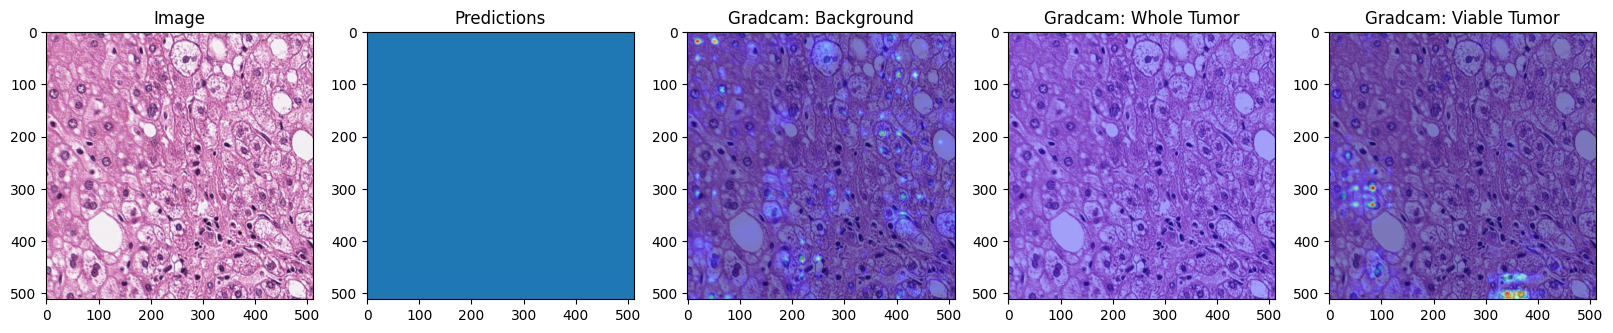

In [145]:
#display_outputs_gradcam(val_image_batch, val_mask_batch, output, cam_image_bg, cam_image_wt, cam_image_vt)
display_outputs_gradcam(val_image_batch, None, output, cam_image_bg, cam_image_wt, cam_image_vt)

### **Conclusions**